### **AlzheimerClassifierTL: ResNet50-Based Alzheimer’s MRI Classifier**

### **Project Overview**

**AlzheimerClassifierTL** is a deep learning project that classifies brain MRI images into four cognitive health categories:
- **🟢 NonDemented**
- **🟡 Very Mild Demented**
- **🟠 Mild Demented**
- **🔴 Moderate Demented**
AlzheimerClassifierTL: ResNet50-Based Alzheimer’s MRI Classifier
Project Overview
AlzheimerClassifierTL is a deep learning project that classifies brain MRI images into four cognitive health categories:

🟢 NonDemented
🟡 Very Mild Demented
🟠 Mild Demented
🔴 Moderate Demented

The workflow includes **data exploration, visualization, and transfer learning using ResNet50**, followed by deployment as an interactive **Streamlit application** and publication on **Hugging Face**.

### **Objective**
Develop and deploy a reliable **transfer learning model** to support the early detection of **Alzheimer’s disease**, a progressive neurological disorder that impacts **memory** and **cognitive function**.

Early identification of dementia stages can help guide timely medical consultation and care.

### Dataset
- **Source**: [Kaggle – Augmented Alzheimer MRI Dataset](https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset/data)
- Preprocessing:
    - Images resized to **224×224 (RGB)**
    - Normalized using **ResNet50 preprocess_input**
    - Split into **train, validation, and test sets with balanced distribution**


### **Modeling Approach**
- **Base Model**: **ResNet50** pre-trained on ImageNet, with top layers removed and a global max pooling layer added
- **Custom Layers**: Batch normalization, fully connected dense layer (256 units, L1/L2 regularization), and dropout (0.45)
- **Output Layer**: Dense layer with softmax activation for 4-class prediction
- **Training Setup**:
    - **Loss**: Categorical crossentropy
    - **Optimizer**: Adamax (learning rate 0.001)
    - Data augmentation (rotation, width/height shift, zoom, nearest-neighbor fill) applied to training set only
    - Early stopping and model checkpointing to prevent overfitting

### Performance

The final model achieved strong results on the test set:
- **Accuracy**: `98.3%`
- **Precision**: `98.9%`
- **Recall**: `93.8%`
- **F1 Score**: `96.1%`

**Alzheimer’s disease** is a **progressive neurological disorder** that affects the **brain’s ability to think, remember, and carry out daily activities**.
It is the most common cause of **dementia**, gradually **damaging memory** and other important **cognitive functions**.

When Alzheimer’s develops, **abnormal protein deposits** form **plaques and tangles** inside the brain, disrupting communication between nerve cells and eventually causing them to die.

**Key signs and symptoms include**:
- Persistent memory loss, especially of recent events
- Difficulty planning or solving problems
- Confusion with time, place, or familiar tasks
- Changes in mood, personality, or behavior

### Risk factors:
- Age (risk increases after 65)
- Family history of Alzheimer’s or dementia
- Lifestyle factors such as **poor cardiovascular health**, **lack of exercise**, or **smoking**

While there is **no cure**, **early detection** is important.

**Medical evaluation**, **cognitive assessments**, **and supportive care** can help manage symptoms, slow progression, and improve quality of life for individuals and their families.

### Import Necessary Libraries

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import hashlib
import random
from PIL import Image
import itertools
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam , Adamax  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.models import load_model
from huggingface_hub import login
from huggingface_hub import HfApi
from huggingface_hub import hf_hub_download
from dotenv import load_dotenv
import warnings 
warnings.filterwarnings("ignore")

### Dataset Loading

In [ ]:
base_dir = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset" # this is the main directory or this is the directory that contains all the folders of all the images 

unexpected_files = [] 

for root, _, files in os.walk(base_dir): 
    for f in files: 
        if not f.lower().endswith(".jpg"): 
            unexpected_files.append(os.path.join(root, f)) 
if unexpected_files: 
    print("⚠️ Found unexpected files:")
    for uf in unexpected_files: 
        print(uf)
else: 
    print("✅ All files are .jpg")

✅ All files are .jpg


In [ ]:
def is_image_file(filename): 
    return filename.lower().endswith(".jpg")

image_paths = [] 
image_labels = [] 

for class_name in os.listdir(base_dir): 
    class_path = os.path.join(base_dir, class_name) 

    if not os.path.isdir(class_path): 
        continue

    for image_file in os.listdir(class_path): 
        if is_image_file(image_file): 
            full_path = os.path.join(class_path, image_file) 
            image_paths.append(full_path) 
            image_labels.append(class_name) 


df = pd.DataFrame({"image_path": image_paths, "label": image_labels})
print(f"✅ Total valid images: {len(df)}") 
df.head() 

✅ Total valid images: 6400


,image_path,label
0,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
1,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
2,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
3,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
4,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented


### Data Exploration and Visualization

In [ ]:
df["label"].value_counts() 

label
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64

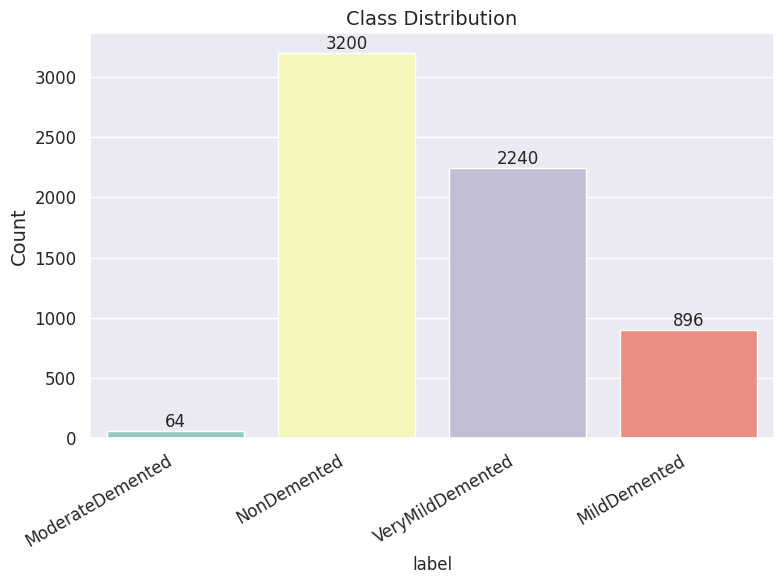

In [ ]:
plt.figure(figsize=(8, 6))  

ax = sns.countplot(data=df, x='label', palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"
    )


plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=14)

plt.tight_layout()
plt.show()


### Duplicate Image Detection

In [7]:
def find_duplicates_in_df(df):
    """Find duplicate images in a DataFrame using MD5 hashes."""
    hashes = {}
    duplicates = []

    for row in df.itertuples():
        image_path = row.image_path
        label = row.label

        try:
            with open(image_path, "rb") as f:
                img_hash = hashlib.md5(f.read()).hexdigest()
                if img_hash in hashes:
                    duplicates.append((label, image_path, hashes[img_hash]))
                else:
                    hashes[img_hash] = image_path
        except Exception as e:
            print(f"⚠️ Error processing {image_path}: {e}")

    df_duplicates = pd.DataFrame(
        duplicates,
        columns=["Label", "Duplicate Path", "Original Path"]
    )

    print(f"✅ Found {len(df_duplicates)} duplicates in dataset")
    return df_duplicates


def display_duplicate_images(df_duplicates, max_samples=5):  
    """Display a few duplicate/original pairs."""
    if df_duplicates.empty:
        print("No duplicates to display.")
        return

    num_samples = min(len(df_duplicates), max_samples)
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

    for i, row in enumerate(df_duplicates.iloc[:num_samples].itertuples()):
        try:
            original = Image.open(row._3)  
            duplicate = Image.open(row._2) 

            axes[i, 0].imshow(original, cmap="gray")
            axes[i, 0].set_title(f"Original ({row.Label})")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(duplicate, cmap="gray")
            axes[i, 1].set_title("Duplicate")
            axes[i, 1].axis("off")

        except Exception as e:
            print(f"⚠️ Error displaying images: {e}")

    plt.tight_layout()
    plt.show()

In [8]:
df_duplicates = find_duplicates_in_df(df)

display_duplicate_images(df_duplicates, max_samples=5)

✅ Found 0 duplicates in dataset
No duplicates to display.


### Check for Corrupted Files

In [ ]:
def find_corrupted_images(df): 
    corrupted = [] 

    for row in df.itertuples(): 
        image_path = row.image_path 
        try:
            img = Image.open(image_path) 
            img.verify() 
        except Exception as e: 
            corrupted.append((image_path, str(e))) 

    df_corrupted = pd.DataFrame(corrupted, columns=["Image Path", "Error"]) 
    print(f"✅ Found {len(df_corrupted)} corrupted images") 
    return df_corrupted 


df_corrupted = find_corrupted_images(df) 

if not df_corrupted.empty
    print(df_corrupted.head())
else: 
    print("No corrupted images found 🚀")

✅ Found 0 corrupted images
No corrupted images found 🚀


### Visualize Sample Images from Each Class

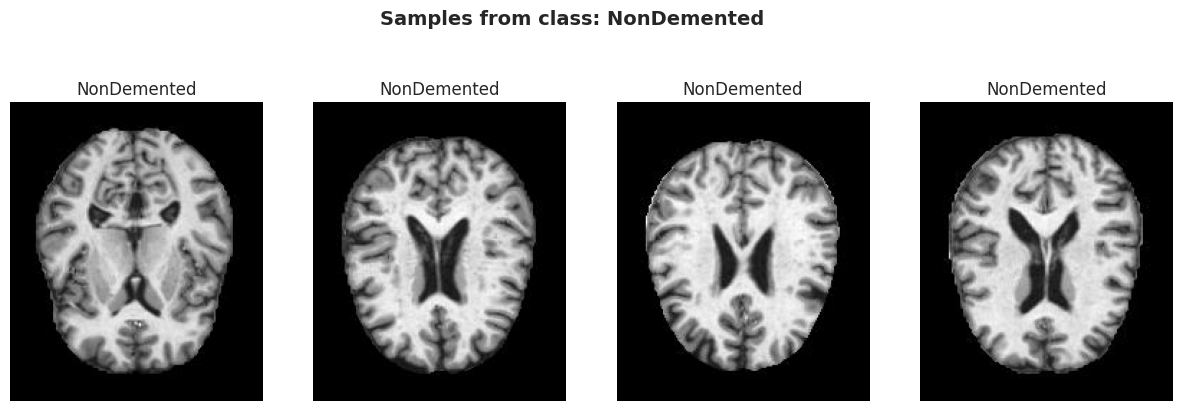

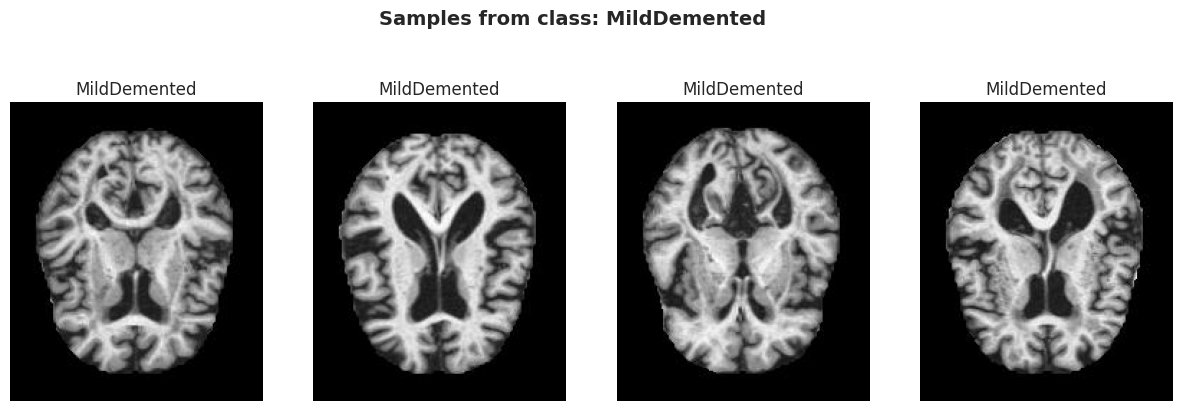

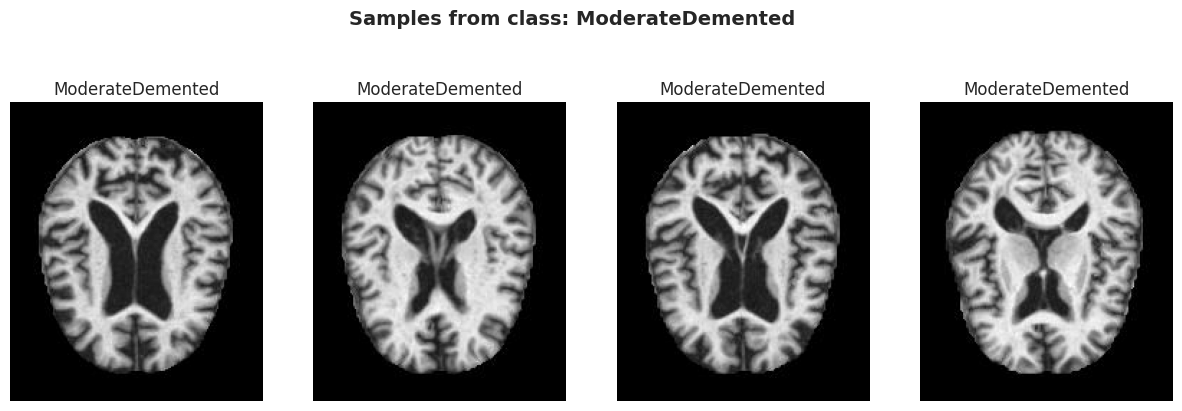

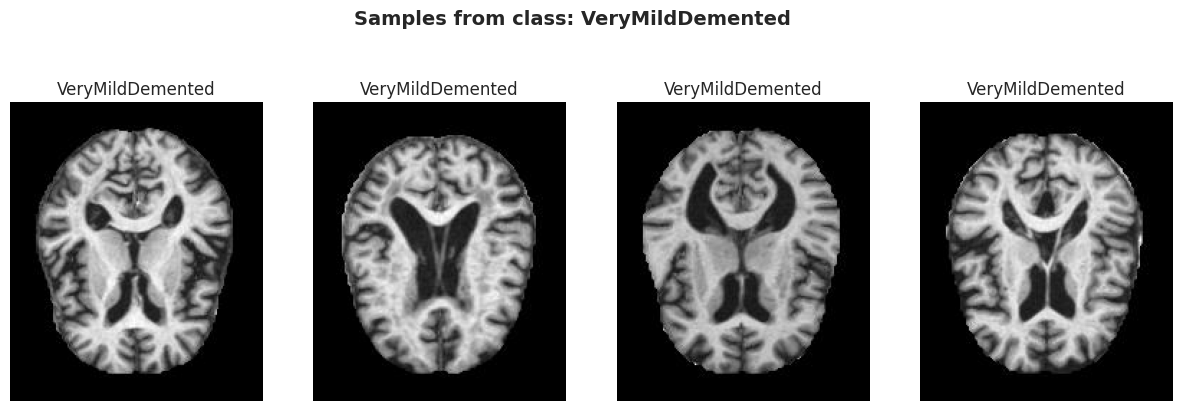

In [ ]:
def show_class_samples(df, class_name, n_samples=4): 
    """Display n_samples images from a given class."""
    sample_df = df[df["label"] == class_name].sample(n_samples, random_state=42)

    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    fig.suptitle(f"Samples from class: {class_name}", fontsize=14, fontweight="bold")

    for i, row in enumerate(sample_df.itertuples()):
        img = Image.open(row.image_path).convert("L")
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(class_name)
        axes[i].axis("off")

    plt.show()


show_class_samples(df, "NonDemented", n_samples=4)
show_class_samples(df, "MildDemented", n_samples=4)
show_class_samples(df, "ModerateDemented", n_samples=4)
show_class_samples(df, "VeryMildDemented", n_samples=4)

### Splitting Data into Training and Testing Sets

In [ ]:
df_train, df_test = train_test_split(
    df, 
    test_size=0.1, 
    stratify=df["label"],
    random_state=42
)

df_train, df_val = train_test_split(
    df_train, 
    test_size=0.1,
    stratify=df_train["label"],
    random_state=42
)

print("Train size:", len(df_train)) 
print("Val size:", len(df_val)) 
print("Test size:", len(df_test))

Train size: 5184
Val size: 576
Test size: 640


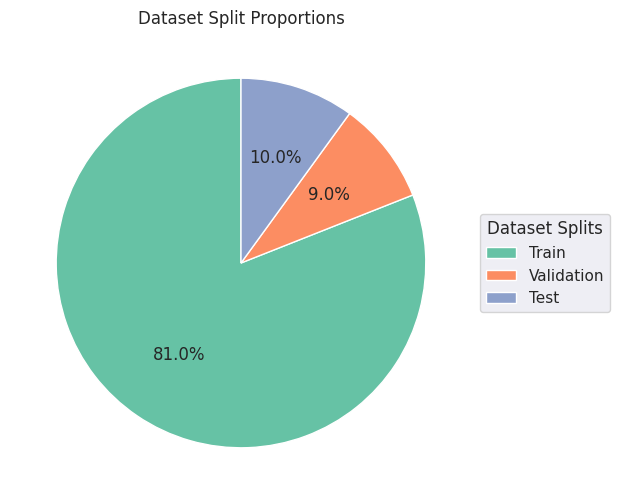

In [ ]:
split_counts = {
    "Train": len(df_train),
    "Validation": len(df_val),
    "Test": len(df_test)
}

labels = list(split_counts.keys()) 
sizes = list(split_counts.values()) 

colors = plt.cm.Set2.colors[:len(labels)]


plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors
)


plt.legend(
    wedges, labels, 
    title="Dataset Splits", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Dataset Split Proportions")
plt.show()

In [ ]:
df_splits = pd.DataFrame(list(split_counts.items()), columns=["Split", "Count"])
df_splits

,Split,Count
0,Train,5184
1,Validation,576
2,Test,640


In [ ]:
print(df["label"].value_counts(normalize=True).mul(100).round(1))
print("="*100)
print(df_train["label"].value_counts(normalize=True).mul(100).round(1))
print("="*100)
print(df_val["label"].value_counts(normalize=True).mul(100).round(1))
print("="*100)
print(df_test["label"].value_counts(normalize=True).mul(100).round(1))


label
NonDemented         50.0
VeryMildDemented    35.0
MildDemented        14.0
ModerateDemented     1.0
Name: proportion, dtype: float64
label
NonDemented         50.0
VeryMildDemented    35.0
MildDemented        14.0
ModerateDemented     1.0
Name: proportion, dtype: float64
label
NonDemented         50.0
VeryMildDemented    35.1
MildDemented        13.9
ModerateDemented     1.0
Name: proportion, dtype: float64
label
NonDemented         50.0
VeryMildDemented    35.0
MildDemented        14.1
ModerateDemented     0.9
Name: proportion, dtype: float64


In [ ]:
df_train['label'].value_counts()

label
NonDemented         2592
VeryMildDemented    1814
MildDemented         726
ModerateDemented      52
Name: count, dtype: int64

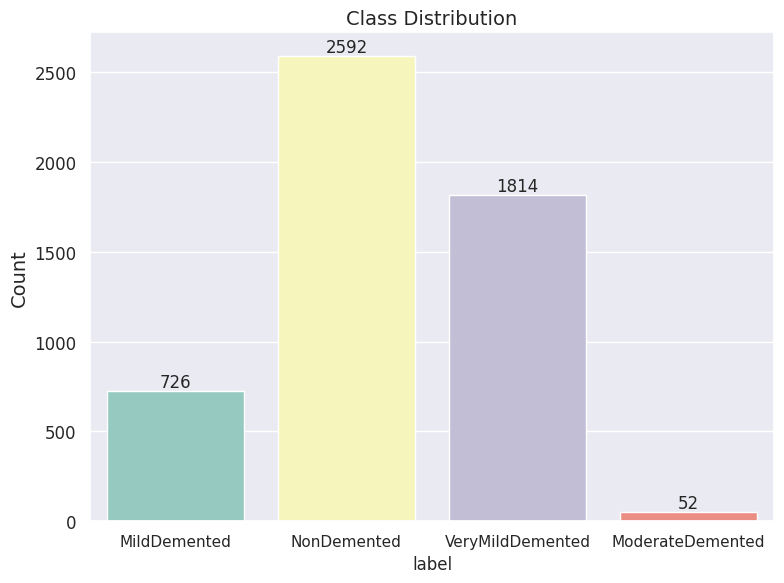

In [ ]:
plt.figure(figsize=(8, 6))  

ax = sns.countplot(data=df_train, x='label', palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"
    )


plt.yticks(fontsize=12)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=14)

plt.tight_layout()
plt.show()

In [17]:
df_val['label'].value_counts()

label
NonDemented         288
VeryMildDemented    202
MildDemented         80
ModerateDemented      6
Name: count, dtype: int64

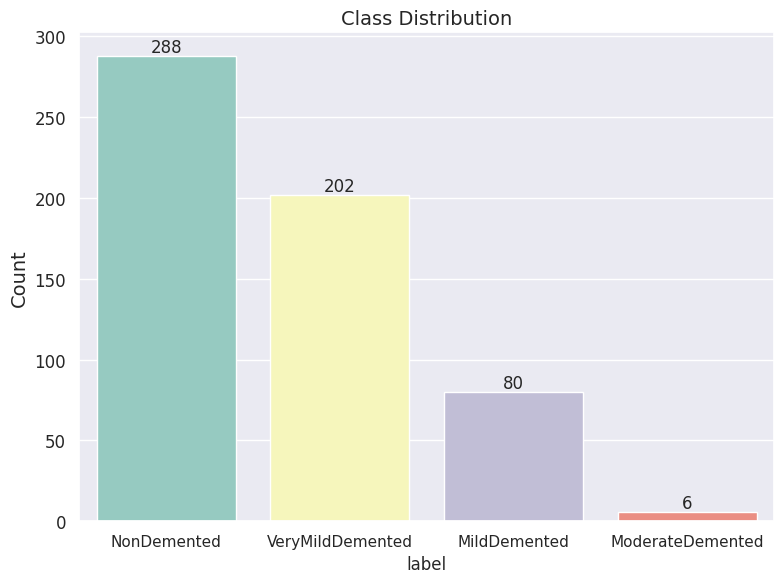

In [18]:
plt.figure(figsize=(8, 6))  

ax = sns.countplot(data=df_val, x='label', palette='Set3')

# Annotate counts
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"
    )


plt.yticks(fontsize=12)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=14)

plt.tight_layout()
plt.show()

In [19]:
df_test['label'].value_counts()

label
NonDemented         320
VeryMildDemented    224
MildDemented         90
ModerateDemented      6
Name: count, dtype: int64

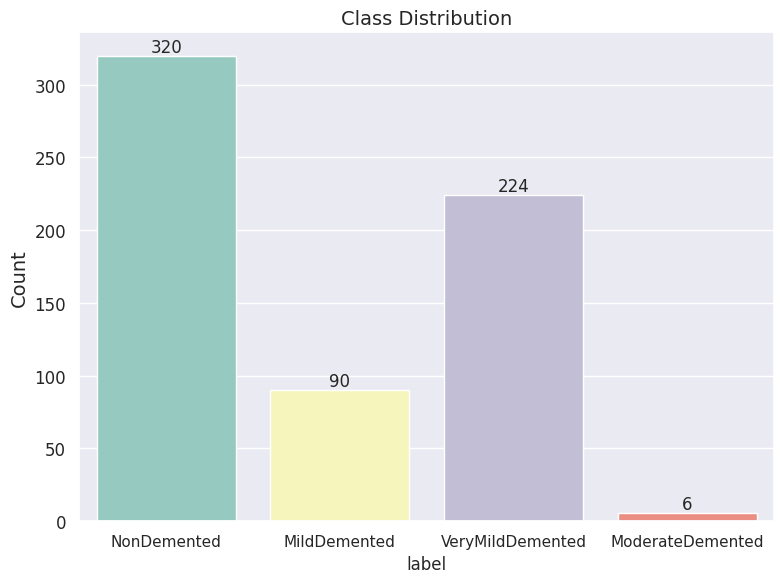

In [20]:
plt.figure(figsize=(8, 6))  

ax = sns.countplot(data=df_test, x='label', palette='Set3')

# Annotate counts
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"
    )


plt.yticks(fontsize=12)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32 


train_image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=1,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.1,
    fill_mode="nearest"
)

val_test_image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_image_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",           
    class_mode="categorical", 
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=42
)

val_generator = val_test_image_generator.flow_from_dataframe(
    dataframe=df_val,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical", 
    shuffle=False,
    batch_size=BATCH_SIZE
)

test_generator = val_test_image_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical", 
    shuffle=False,
    batch_size=BATCH_SIZE
)

Found 5184 validated image filenames belonging to 4 classes.
Found 576 validated image filenames belonging to 4 classes.
Found 640 validated image filenames belonging to 4 classes.


In [ ]:
print("Train class indices:", train_generator.class_indices)
print("Val class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

Train class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Val class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Test class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [ ]:
print("The total number of the training batches in the single training epoch is",len(train_generator))
print("The total number of the validation batches",len(val_generator))
print("The total number of the testing batches",len(test_generator))

The total number of the training batches in the single training epoch is 162
The total number of the validation batches 18
The total number of the testing batches 20


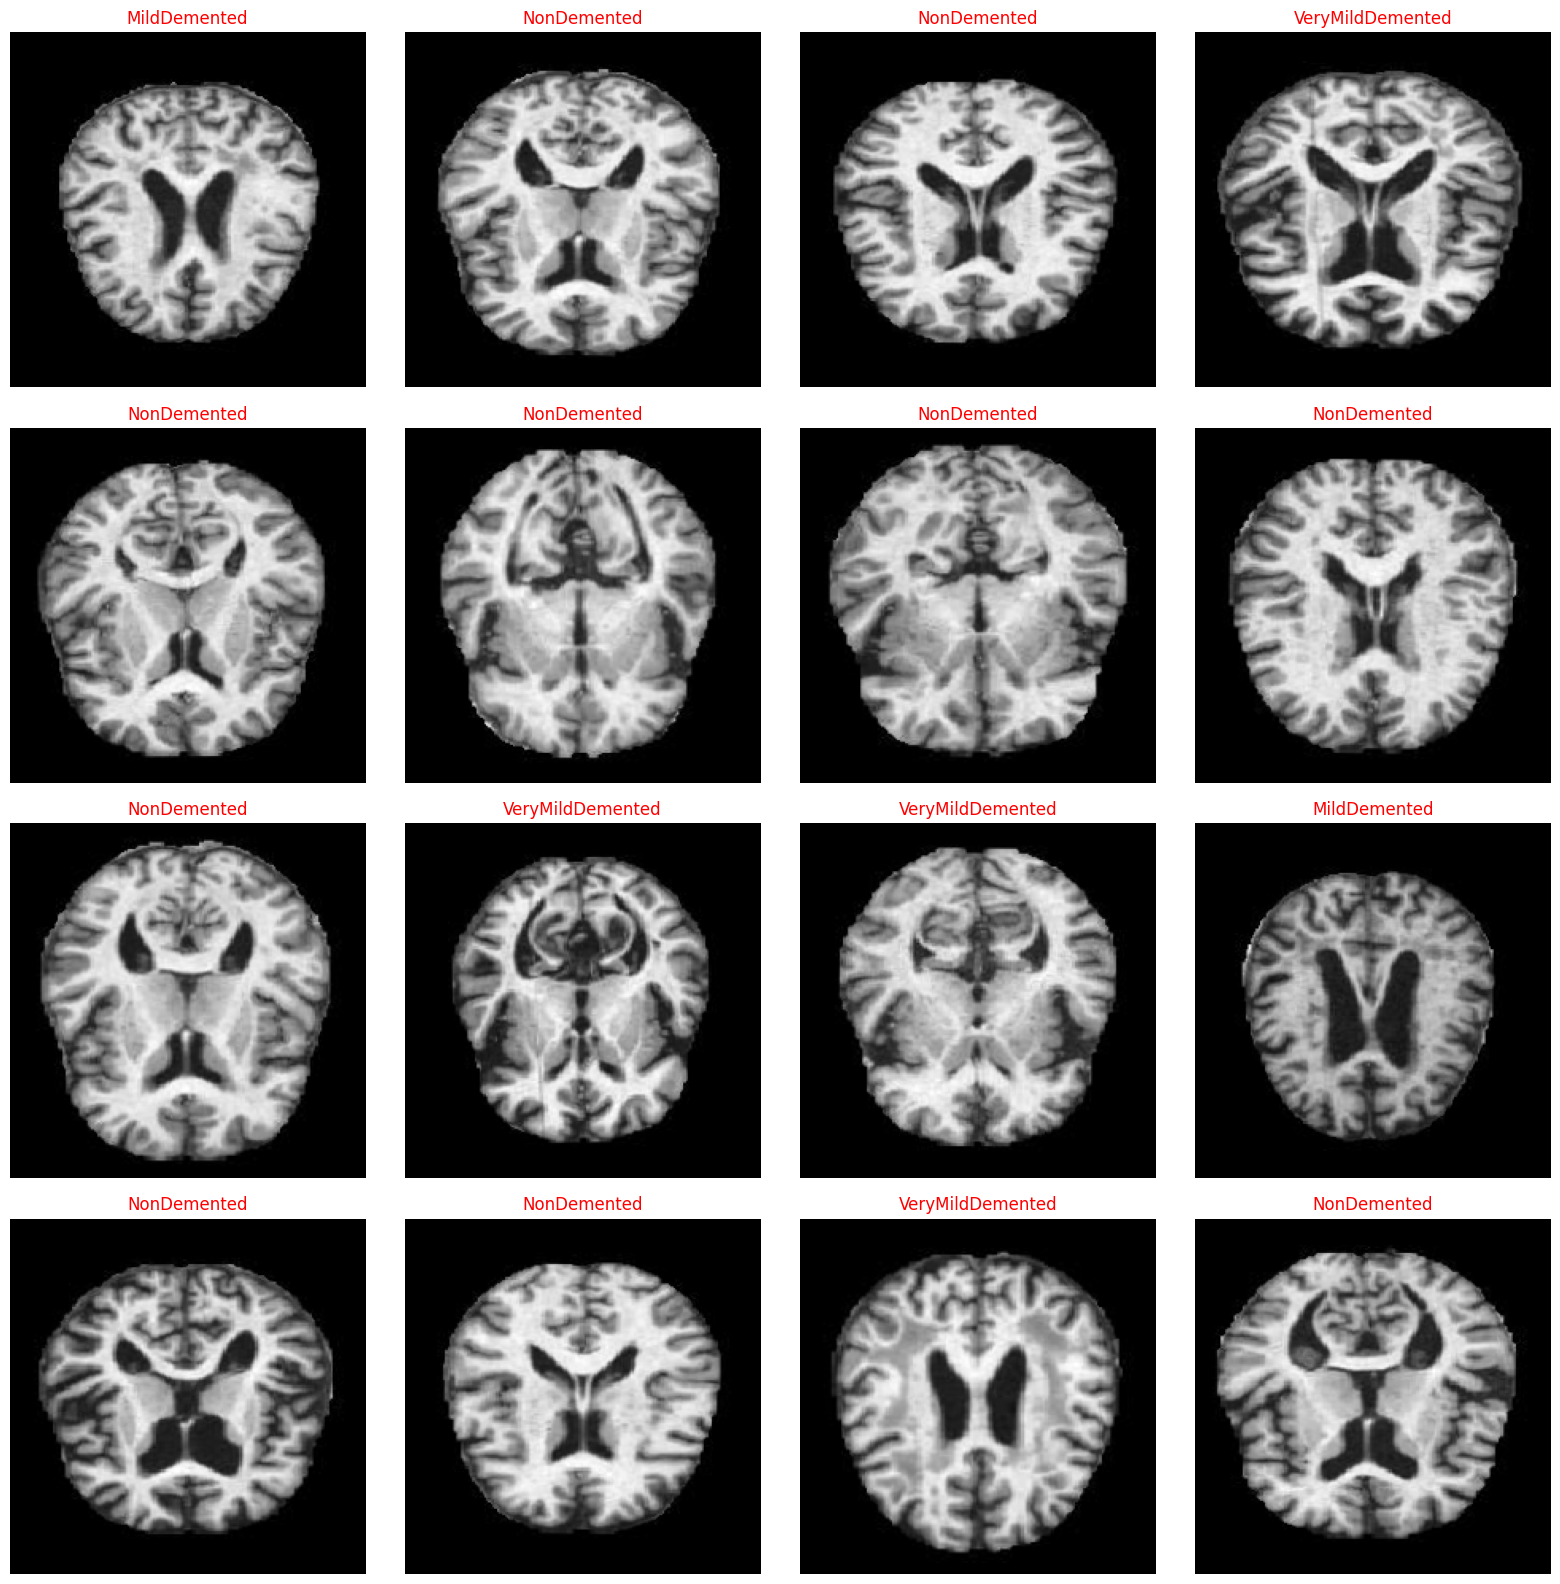

In [ ]:
images, labels = next(train_generator) 

class_indices = train_generator.class_indices 
classes = list(class_indices.keys())

plt.figure(figsize=(16, 16))
for i in range(16): 
    plt.subplot(4, 4, i + 1)

    image = images[i][:, :, 0]
    plt.imshow(image, cmap="gray")

    index = np.argmax(labels[i])
    class_name = classes[index]

    plt.title(class_name, color="red", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

### **Training ResNet50 for Alzheimer’s MRI Classification**

### **About ResNet50**

ResNet50 is a deep convolutional neural network with **50 layers**, part of the **Residual Network (ResNet) family**.

Its key innovation is the use of **skip connections (residual blocks)**, which help mitigate the **vanishing gradient problem** and allow training of much deeper models effectively.

The model is pretrained on **ImageNet**, providing strong feature extraction capabilities for transfer learning.

By setting `include_top=False`, we remove the original classification layer and add a **custom dense head** with **softmax activation** for our **4 Alzheimer’s categories**:
- NonDemented
- VeryMildDemented
- MildDemented
- ModerateDemented

### **Why Transfer Learning with ResNet50?**
Training a deep CNN from scratch requires massive datasets and compute resources.

**Transfer learning** leverages the pretrained knowledge of ResNet50 (trained on millions of images) and adapts it to **medical MRI data**.

This approach:
- Improves **accuracy** on limited datasets
- Provides **better generalization** across patient scans
- Significantly reduces **training time and compute requirements**

In this project, **ResNet50** acts as a powerful feature extractor, while the added custom layers

In [ ]:
IMG_SIZE = (224, 224) 
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS) 
NUM_CLASSES = 4 


base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    pooling="max"
)

model = Sequential([
    base_model, 
    BatchNormalization(), 
    Dense(256, 
          kernel_regularizer=regularizers.l2(0.001), 
          activity_regularizer=regularizers.l1(0.0001),
          bias_regularizer=regularizers.l1(0.00001),
          activation="relu"), 
    Dropout(0.45, seed=42), 
    Dense(NUM_CLASSES, activation="softmax") 
])


model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="categorical_crossentropy",  
    metrics=["accuracy"]
)
model.summary()

I0000 00:00:1758985867.012126      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758985867.012816      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,121,476 (92.02 MB)

 Trainable params: 24,064,260 (91.80 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True, 
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "best_resnet50.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max", 
    verbose=1
)

In [ ]:
EPOCHS = 20 
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=val_generator, 
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20


I0000 00:00:1758986084.982281     105 service.cc:148] XLA service 0x7fede4003b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758986084.983734     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758986084.983756     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758986088.725049     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758986111.223399     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.4835 - loss: 2.4803
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_resnet50.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 146s 463ms/step - accuracy: 0.4839 - loss: 2.4781 - val_accuracy: 0.5000 - val_loss: 5.0815
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6859 - loss: 1.5191
Epoch 2: val_accuracy improved from 0.50000 to 0.65972, saving model to best_resnet50.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.6862 - loss: 1.5185 - val_accuracy: 0.6597 - val_loss: 1.8393
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8101 - loss: 1.1527
Epoch 3: val_accuracy improved from 0.65972 to 0.83333, saving model to best_resnet50.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 65s 400ms/step - accuracy: 0.8102 - loss: 1.1523 - val_accuracy: 0.8333 - val_loss: 1.1276
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8971 - loss: 0.9427
Epoch 4: val_accuracy did not impr

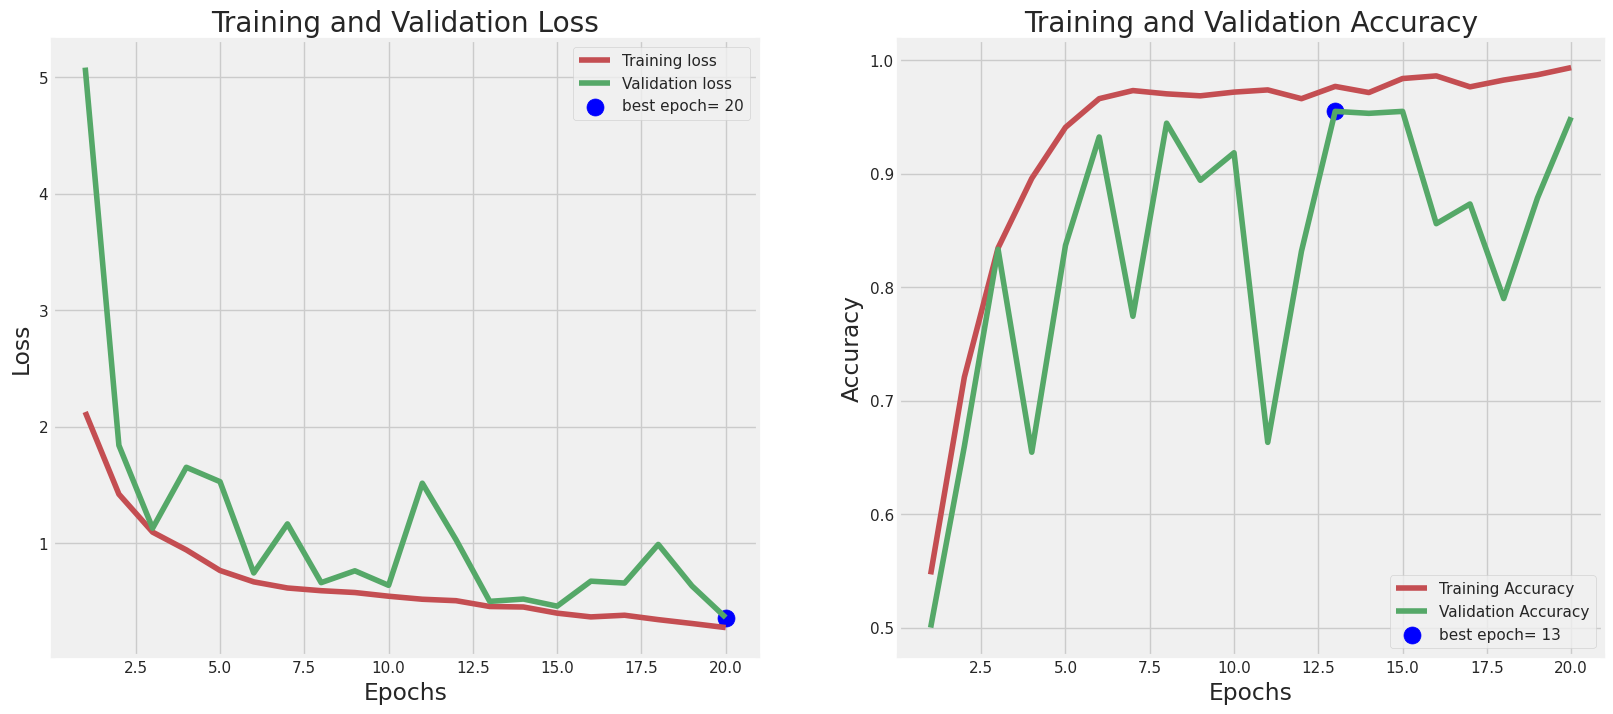

In [29]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(val_generator, verbose= 1)
test_score = model.evaluate(test_generator, verbose= 1)

print("\nTrain Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

162/162 ━━━━━━━━━━━━━━━━━━━━ 61s 374ms/step - accuracy: 0.9595 - loss: 0.3388
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9409 - loss: 0.3730
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9588 - loss: 0.3336

Train Loss:  0.33489564061164856
Train Accuracy:  0.9594907164573669
--------------------
Validation Loss:  0.36123132705688477
Validation Accuracy:  0.9496527910232544
--------------------
Test Loss:  0.3281700611114502
Test Accuracy:  0.9609375


In [ ]:
y_pred_prob = model.predict(test_generator)
y_pred_prob

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step


array([[7.2573737e-04, 2.3464161e-04, 9.9749988e-01, 1.5397370e-03],
       [2.3924164e-02, 7.4957684e-03, 5.6967402e-01, 3.9890608e-01],
       [7.4923927e-01, 2.1418709e-02, 5.8180191e-02, 1.7116188e-01],
       ...,
       [1.7515892e-03, 5.8561959e-04, 5.9824958e-03, 9.9168020e-01],
       [5.8960298e-04, 7.5839300e-05, 1.0014536e-03, 9.9833316e-01],
       [5.7141700e-05, 6.7537580e-06, 1.0455264e-04, 9.9983144e-01]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

array([2, 2, 0, 3, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 3, 3, 0, 3, 3, 2,
       2, 2, 0, 2, 3, 2, 3, 2, 2, 3, 3, 2, 2, 3, 2, 0, 2, 2, 3, 3, 2, 2,
       3, 3, 2, 3, 0, 3, 0, 2, 1, 2, 3, 2, 2, 2, 0, 3, 3, 2, 3, 3, 0, 2,
       2, 2, 0, 2, 3, 2, 3, 1, 2, 2, 2, 3, 2, 0, 3, 2, 2, 0, 2, 3, 2, 3,
       0, 3, 2, 2, 2, 3, 2, 2, 2, 0, 2, 3, 3, 2, 2, 0, 2, 0, 0, 2, 0, 2,
       0, 2, 3, 1, 3, 0, 3, 2, 2, 3, 0, 0, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3,
       2, 3, 2, 2, 3, 3, 2, 2, 3, 0, 2, 2, 3, 3, 3, 0, 0, 2, 3, 2, 3, 0,
       3, 2, 0, 3, 3, 2, 3, 2, 2, 2, 0, 2, 3, 3, 3, 3, 3, 2, 2, 0, 3, 2,
       3, 3, 0, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 0, 2, 0, 0, 3, 2, 3,
       3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 3, 3, 2, 3,
       3, 2, 2, 2, 3, 0, 2, 3, 3, 2, 2, 3, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 2, 2, 3, 2, 0, 3, 0, 3, 2, 0, 3, 3, 3, 2, 3, 3, 3, 2, 3,
       2, 3, 3, 3, 3, 2, 3, 2, 0, 0, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2,
       2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 0, 2, 2,

In [ ]:
y_true = test_generator.classes
y_true

[2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 0,
 3,
 3,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 3,
 2,
 0,
 2,
 2,
 3,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 0,
 3,
 0,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 0,
 3,
 3,
 2,
 3,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 3,
 2,
 3,
 1,
 2,
 2,
 2,
 3,
 3,
 0,
 3,
 2,
 2,
 0,
 2,
 3,
 2,
 3,
 0,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 0,
 0,
 2,
 3,
 3,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 3,
 1,
 3,
 0,
 3,
 2,
 2,
 3,
 0,
 0,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 3,
 0,
 2,
 2,
 3,
 3,
 3,
 0,
 0,
 2,
 3,
 2,
 3,
 0,
 3,
 2,
 0,
 3,
 3,
 2,
 3,
 2,
 2,
 2,
 0,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 0,
 3,
 2,
 3,
 3,
 0,
 2,
 2,
 3,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 0,
 2,
 0,
 0,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 2,
 3,
 0,
 2,
 3,
 3,
 2,
 2,
 3,
 0,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 2,
 3,
 2,
 0,


In [34]:
CM = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", CM)

Confusion Matrix:
 [[ 86   0   1   3]
 [  0   6   0   0]
 [  0   0 302  18]
 [  0   0   3 221]]


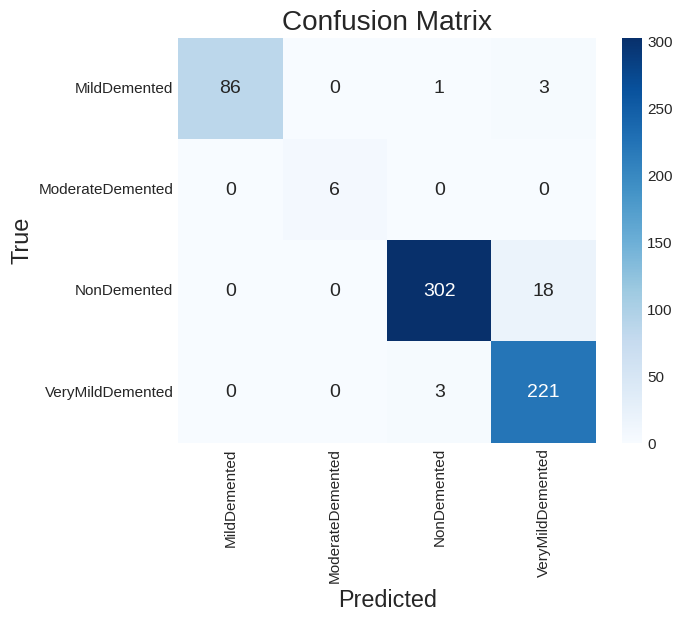

In [35]:
plt.style.use("seaborn-white")
plt.figure(figsize=(6,5))
sns.heatmap(CM, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [36]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9609
Precision: 0.9750
Recall:    0.9715
F1 Score:  0.9727


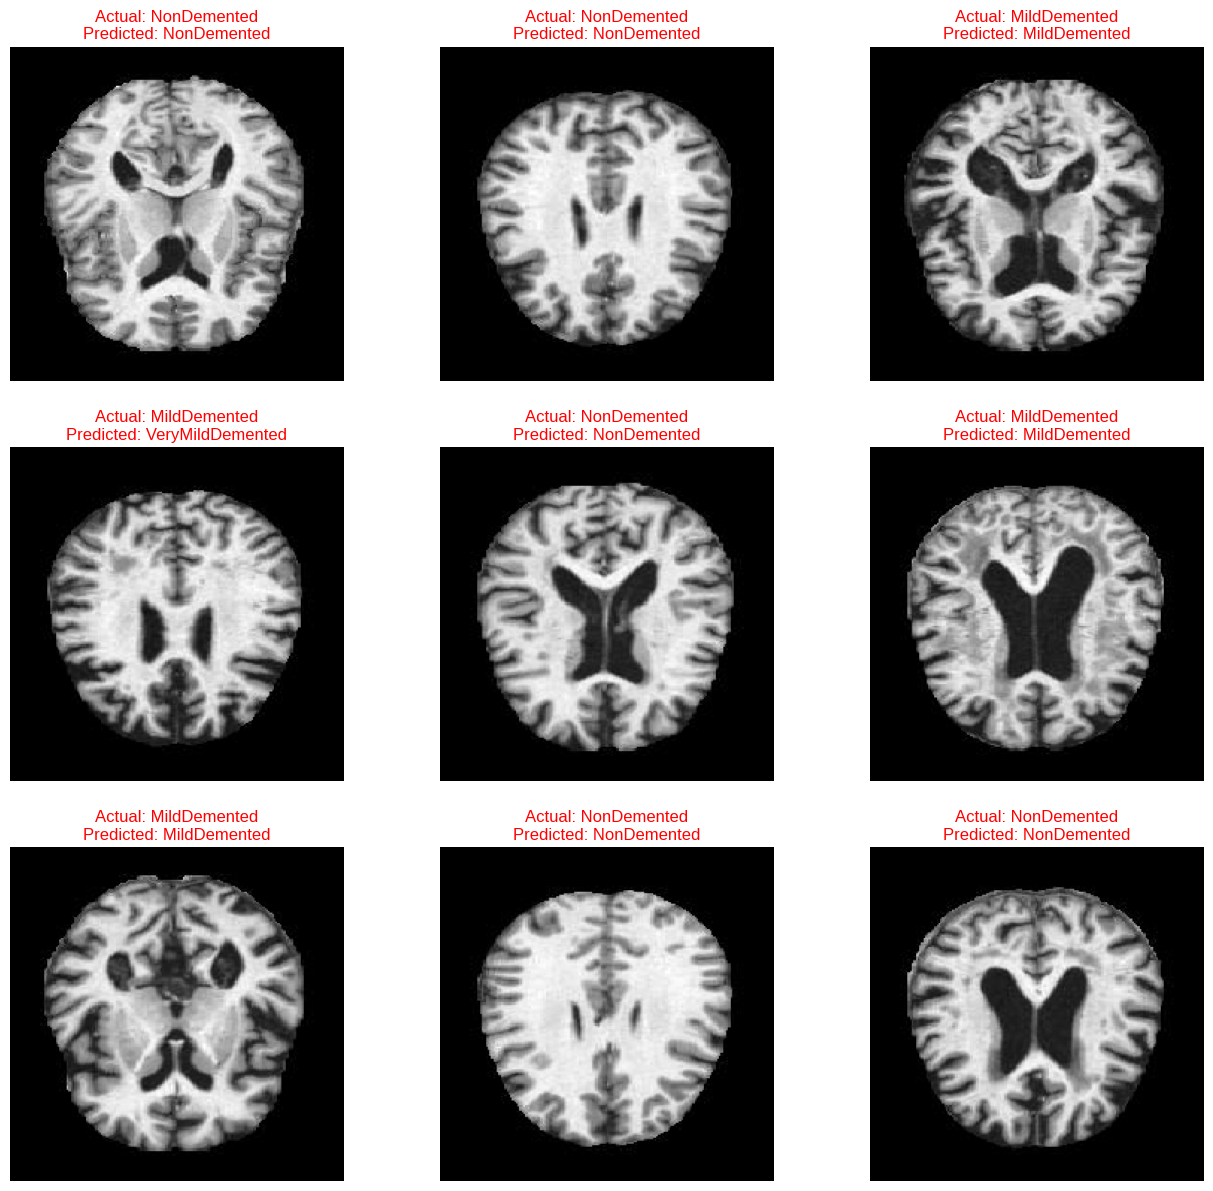

In [ ]:
images, labels = next(test_generator)
class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(14, 14))

for i in range(9):  
    image = images[i] 
    true_label_onehot = labels[i] 
    true_label_idx = np.argmax(true_label_onehot) 
    true_label_name = idx_to_class[true_label_idx] 

    pred = model.predict(np.expand_dims(image, axis=0), verbose=0) 
    predicted_idx = np.argmax(pred, axis=1)[0] 
    predicted_class = idx_to_class[predicted_idx] 

    plt.subplot(3, 3, i + 1)
    plt.imshow(image[..., 0], cmap="gray") 
    plt.title(f"Actual: {true_label_name}\nPredicted: {predicted_class}", fontsize=12, color="red")
    plt.axis("off")

plt.show()

Authenticate with Hugging Face Hub

In [45]:
load_dotenv()
token = os.getenv("HUGGINGFACE_TOKEN")
login(token=token)

In [ ]:
api = HfApi()

repo_id = "Eyaddddddd/AlzheimerClassifierTL"

api.create_repo(repo_id=repo_id, repo_type="model", private=True, exist_ok=True)

print(f"✅ Repo created: https://huggingface.co/{repo_id}")

local_model_path = "/kaggle/working/best_resnet50.h5" 

api.upload_file(
    path_or_fileobj=local_model_path,
    path_in_repo="AlzheimerClassifierTL.h5",   
    repo_id=repo_id,
    repo_type="model"
)

print(f"✅ Model uploaded to: https://huggingface.co/{repo_id}/blob/main/AlzheimerClassifierTL.h5")

✅ Repo created: https://huggingface.co/Eyaddddddd/AlzheimerClassifierTL


Uploading...:   0%|          | 0.00/290M [00:00<?, ?B/s]

✅ Model uploaded to: https://huggingface.co/Eyaddddddd/AlzheimerClassifierTL/blob/main/AlzheimerClassifierTL.h5


Load and Test Model from Hugging Face Hub

In [ ]:
model_path = hf_hub_download(
    repo_id="Eyaddddddd/AlzheimerClassifierTL", 
    filename="AlzheimerClassifierTL.h5"  

model = load_model(model_path)
print("✅ Model loaded from Hugging Face:", model_path)

AlzheimerClassifierTL.h5:   0%|          | 0.00/290M [00:00<?, ?B/s]

✅ Model loaded from Hugging Face: /root/.cache/huggingface/hub/models--Eyaddddddd--AlzheimerClassifierTL/snapshots/a7c3e73ca7db4097edac9b0f7bd617ee5b166d46/AlzheimerClassifierTL.h5


In [ ]:
class_mapping = {
    "MildDemented": 0,
    "ModerateDemented": 1,
    "NonDemented": 2,
    "VeryMildDemented": 3
}

def preprocess_image(image_path): 
    IMG_SIZE = (224, 224) 
    image = Image.open(image_path).convert("RGB") 
    image = image.resize(IMG_SIZE) 
    img_array = np.array(image) 
    img_array = preprocess_input(img_array) 
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array


def predict_and_show(image_path):
    img_array = preprocess_image(image_path)

    prediction = model.predict(img_array)[0] 
    predicted_idx = np.argmax(prediction) 
    probability = prediction[predicted_idx] 

    idx_to_class = {v: k for k, v in class_mapping.items()}
    predicted_class = idx_to_class[predicted_idx]

    messages = {
        "NonDemented": "✅ Likely Healthy / No Dementia detected",
        "VeryMildDemented": "🟡 Signs of Very Mild Dementia",
        "MildDemented": "🟠 Signs of Mild Dementia",
        "ModerateDemented": "🔴 Signs of Moderate Dementia"
    }
    message = messages.get(predicted_class, "ℹ️ Prediction result")

    plt.imshow(Image.open(image_path).convert("L"), cmap="gray")
    plt.axis("off")
    plt.show()

    print(f"Predicted Class: {predicted_class}")
    print(message)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


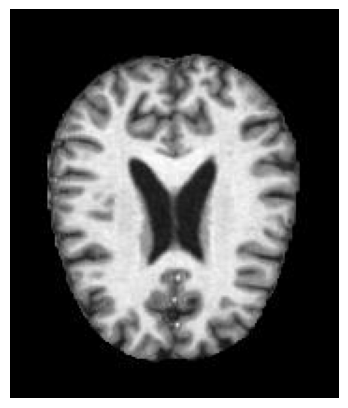

Predicted Class: NonDemented
✅ Likely Healthy / No Dementia detected


In [50]:
predict_and_show("No Dementia.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


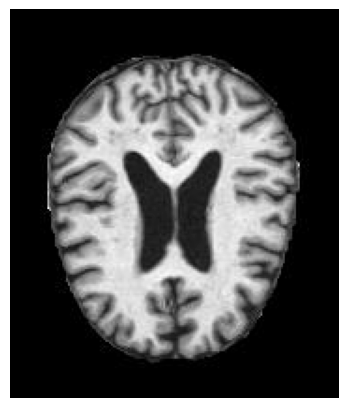

Predicted Class: VeryMildDemented
🟡 Signs of Very Mild Dementia


In [51]:
predict_and_show("Very Mild Dementia.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


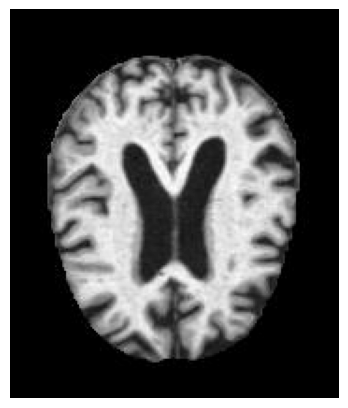

Predicted Class: MildDemented
🟠 Signs of Mild Dementia


In [52]:
predict_and_show("Mild Dementia.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


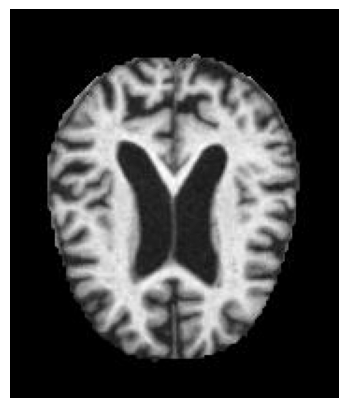

Predicted Class: ModerateDemented
🔴 Signs of Moderate Dementia


In [53]:
predict_and_show("Moderate Dementia.jpg")

## **Final Thoughts**
- This project highlights the potential of transfer learning in supporting the early detection of Alzheimer’s disease through brain MRI analysis.
By leveraging the ResNet50 architecture—pre-trained on ImageNet—and combining it with careful preprocessing, balanced data splitting, and data augmentation, the model achieved high accuracy, precision, recall, and F1-score, enabling reliable classification across the four cognitive health categories: NonDemented, Very Mild Demented, Mild Demented, and Moderate Demented.

- Key regularization techniques such as early stopping and model checkpointing effectively prevented overfitting, ensuring that the model generalizes well to unseen MRI scans.
The integration of batch normalization, dropout, and L1/L2 regularization further strengthened the model’s robustness, while the use of ResNet50’s deep feature extraction captured subtle brain patterns associated with different dementia stages.

---
**Thank you for exploring the AlzheimerClassifierTL project.**